# SpeechToText and ScoreTextConcept
In this demo, we will go through a sample project to show how to build a project by applying **`SpeechToText`** and **`ScoreTextConcept`** Template.

------ *Please note this version is for internal use only* ------

In [1]:
# Connect to a esp server
# Please recplace the <server> and <port> with valid value

import esppy
esp = esppy.ESP('<server>:<port>')

- First, let's create a project

In [2]:
proj_name = "Sound_Insights_project"
proj = esp.create_project(proj_name)

- Then we may define a source window for audio input and add the window to our newly created project.

In [3]:
# Define a source window for audio input
audio = esp.SourceWindow(schema=('sessionID*:string', 'sessionAudio:string'), 
                         index_type='empty',insert_only=True)

# Add the source window to project
source_name = 'Audio_Input_source'
proj.windows[source_name] = audio

- Next, we can define a **`SpeechToText`** template, which process the audio from source window and generate corresponding text.

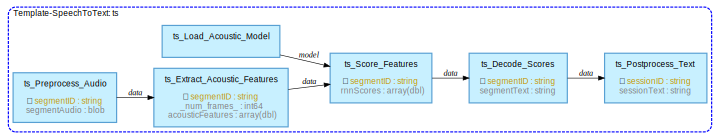

In [4]:
# Define a SpeechToText template named 'ts'
ts = esp.Template.SpeechToText(template_name='ts', preprocessMAS={'source':source_name})

# Show the detail of template
ts_graph = ts.to_graph(detail=True,schema=True)
ts_graph.attr(size = "10, 5")
ts_graph

In [5]:
# Show the input_window and output_windows of the template 'ts'

print(f'input_windows: {ts.input_windows}\noutput_windows: {ts.output_windows}')

input_windows: Preprocess_Audio
output_windows: Postprocess_Text


- Then we add connections between the source window and SpeechToText template, and add the template to project as well.

INFO: Update MAS source for ts_Postprocess_Text
INFO: Update MAS source for ts_Preprocess_Audio


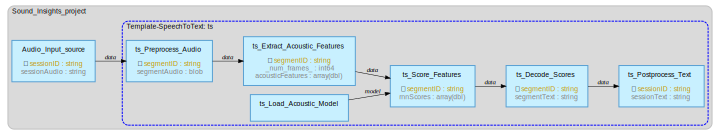

In [6]:
# connect source window with the SpeechToText template
# Note: the input_window from template will be added as a target to audio by default
audio.add_target(ts, role='data')

# Add template to project as well
proj.add_template(ts)

# Show project detail
project_graph = proj.to_graph(template_detail=True,schema=True)
project_graph.attr(size = "10, 5")
project_graph


# ########################################################################
# Please note: The INFO messages regarding MAS source updates 
# are to inform the interanl updates when adding the template to a project, 
# which are expected and NOT exceptions.
# ########################################################################

- Here we define a **`ScoreTextConcept`** template and connect the SpeechToText template with it. 
- This template will score the text (output from SpeechToText template) on a loaded modle for different concepts.

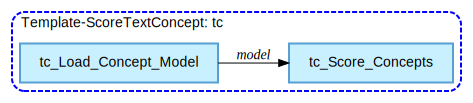

In [7]:
# Define a ScoreTextConcept template named 'tc'
tc = esp.Template.ScoreTextConcept('tc')

# Connect template ts with tc
ts.add_target(tc, role='data')

# Show the detail of template
tc.to_graph(detail=True)

- Finally, we add the template to project and thus the project construction is complete.

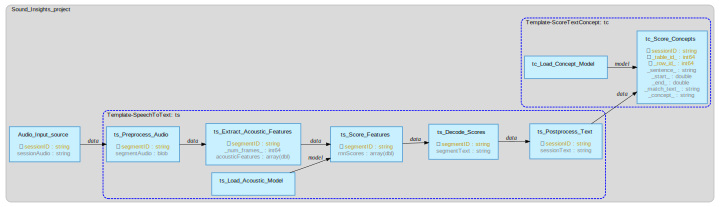

In [8]:
# Add tempalte tc to project
proj.add_template(tc)

# Show the complete project
project_graph = proj.to_graph(template_detail=True,schema=True)
project_graph.attr(size = "10, 5")
project_graph

- Load the project to our esp server

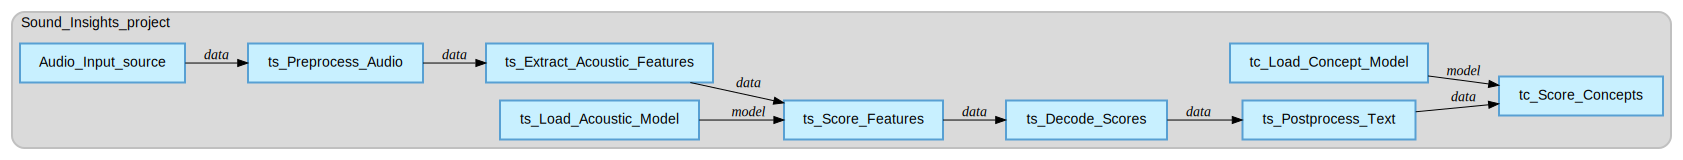

In [9]:
esp.load_project(proj)

- Once the poject is successfully loaded to server, we can send data to source window and check the results.

In [10]:
# create a publisher to send audio input into the ESP server

publisher = audio.create_publisher()
audio.subscribe()

In [11]:
# create subscribers to get outputs from the ESP server
output_segment = proj.windows['ts_Decode_Scores']
output_session = proj.windows['ts_Postprocess_Text']
output_concept = proj.windows['tc_Score_Concepts']

output_segment.subscribe()
output_session.subscribe()
output_concept.subscribe()

In [13]:
# Define a function to send data to source window
def send_audio(publisher, audio_path):
    import base64
    audio_file = open(audio_path, "rb")
    audio_data = audio_file.read()
    audio_file.close()  
    audio_string = base64.b64encode(audio_data)
    audio_string = audio_string.decode()
    audio_to_send = "i,n," + audio_path[audio_path.rfind("/") + 1:audio_path.rfind(".wav")] + "," + audio_string + "\n"
    publisher.send(audio_to_send)


# Send the audio data into ESP server
# Please replace the repository with valid route
send_audio(publisher, "/route_to_file/dec2017_1_Ruqaiya_Shipchandler_12.wav")
send_audio(publisher, "/route_to_file/dec2017_3_Mary_Beth_Ainsworth_15.wav")
send_audio(publisher, "/route_to_file/dec2017_3_Richard_Crowell_13.wav")
send_audio(publisher, "/route_to_file/2019_1_Jared_Peterson_13.wav")
send_audio(publisher, "/route_to_file/2019_3_Brad_Morris_16.wav")

In [20]:
# check the data of source window

audio.reset_index()

,sessionID,sessionAudio
0,dec2017_1_Ruqaiya_Shipchandler_12,UklGRqTGGABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...
1,dec2017_3_Mary_Beth_Ainsworth_15,UklGRiSWGQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...
2,dec2017_3_Richard_Crowell_13,UklGRuRyGABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...


In [21]:
# get the results of transcription (segment)

output_segment.reset_index().iloc[:].style.set_properties(**{'text-align': 'left'})

,segmentID,segmentText
0,dec2017_1_Ruqaiya_Shipchandler_12.0,I JUST GRADUATED TWO WEEKS AGO FROM THE SAS LOCAL PRE SALES ACADEMY ALONG WITH SYSTEMS ENGINEERS FROM FIFTEEN DIFFERENT COUNTRIES
1,dec2017_1_Ruqaiya_Shipchandler_12.1,NOW LIKE TO THINK THAT THERE'S SOMEONE ROOTING FOR ME IN EVERY CORNER OF THE WORLD EXCEPT ANTARA IN MY RELATIVELY SHORT TIME HERE
2,dec2017_1_Ruqaiya_Shipchandler_12.2,I HAVE MET VARIETY OF SMART AND INSPIRING PEOPLE I'VE GAINED SOFT AND TECHNICAL SKILLS
3,dec2017_1_Ruqaiya_Shipchandler_12.3,AND AGAIN I HAD THE OPPORTUNITY TO EXPOSE YOUNG PEOPLE TO THINGS THAT I'M PASSIONATE ABOUT
4,dec2017_1_Ruqaiya_Shipchandler_12.4,IN EARLY NOVEMBER I HAD THE OPPORTUNITY TO SPEAK TO DUKE STUDENTS AT AN ENERGY EVENT
5,dec2017_1_Ruqaiya_Shipchandler_12.5,ABOUT HOW BE TOO COULD LEVERAGE A PASSION AND THE ENERGY INDUSTRY AND A PASSION FOR ANALYTICS JUST LIKE I HAVE RIGHT HERE EXCESS
6,dec2017_1_Ruqaiya_Shipchandler_12.END,FAST FORD TO WRITE NOW


In [22]:
# get the results of transcription (session)

output_session.reset_index().iloc[:].style.set_properties(**{'text-align': 'left'})

,sessionID,sessionText
0,dec2017_1_Ruqaiya_Shipchandler_12,I JUST GRADUATED TWO WEEKS AGO FROM THE SAS LOCAL PRE SALES ACADEMY ALONG WITH SYSTEMS ENGINEERS FROM FIFTEEN DIFFERENT COUNTRIES. NOW LIKE TO THINK THAT THERE'S SOMEONE ROOTING FOR ME IN EVERY CORNER OF THE WORLD EXCEPT ANTARA IN MY RELATIVELY SHORT TIME HERE. I HAVE MET VARIETY OF SMART AND INSPIRING PEOPLE I'VE GAINED SOFT AND TECHNICAL SKILLS. AND AGAIN I HAD THE OPPORTUNITY TO EXPOSE YOUNG PEOPLE TO THINGS THAT I'M PASSIONATE ABOUT. IN EARLY NOVEMBER I HAD THE OPPORTUNITY TO SPEAK TO DUKE STUDENTS AT AN ENERGY EVENT. ABOUT HOW BE TOO COULD LEVERAGE A PASSION AND THE ENERGY INDUSTRY AND A PASSION FOR ANALYTICS JUST LIKE I HAVE RIGHT HERE EXCESS. FAST FORD TO WRITE NOW


In [23]:
# get the results of concepts

concept_result = output_concept.reset_index().iloc[:]
concept_result = concept_result[concept_result["_table_id_"] == 3]
concept_result.style.hide_columns(["_table_id_", "_row_id_", "_sentence_"]).set_properties(**{'text-align': 'left'})

,sessionID,_start_,_end_,_match_text_,_concept_
3,dec2017_1_Ruqaiya_Shipchandler_12,74,83,PASSIONATE,passionateConcept
4,dec2017_1_Ruqaiya_Shipchandler_12,34,40,PASSION,passionateConcept
5,dec2017_1_Ruqaiya_Shipchandler_12,72,78,PASSION,passionateConcept


- Clean the project

In [24]:
# unsubscribe windows

audio.unsubscribe()
output_segment.subscribe()
output_session.subscribe()
output_concept.subscribe()

In [25]:
# delete project

esp.delete_project(proj_name)